## Adaptivity in block Gauss-Seidel SDC
Adaptivity is a scheme for dynamically selecting the optimal step size to solve a problem to a specified accuracy.
The idea is to estimate the error and then choose a step size for the next step to reach the tolerance as best as possible.

### Estimating the error

#### Embedded method in time-serial <a id='embedded_estimate'></a>
The easiest thing to do is an embedded method, where two solutions computed to different order of accuracy are subtracted:
$$\epsilon = \|u^\left(k-1\right)-u^\left(k\right)\| = \|u^\left(k-1\right)-u^*-u^\left(k\right)+u^*\| = e^\left(k-1\right) + \mathcal{O}\left(\Delta t^{k+1}\right),$$
where the superscript in brackets denotes the order of the quantity and $u$ and $u^*$ are the solution and exact solution.
$e$ is the error and $\epsilon$ is the estimate.
As you can see, this estimates the error of the lower order method.
A particularly nice thing is that with SDC the order is equal to the iteration count, so the order $k$ is interchangable with the iteration number in the previous equation.
Notice that you are estimating the local error, meaning the error introduced in this particular step here, since both solutions come from the same initial conditions, which are considered "exact".

#### Embedded method in time-parallel
Block Gauss-Seidel SDC is equivalent to solving the entire block completely with a first order method, then a second order method and so on.
This means that, unlike in the time-serial scheme, the second to last sweep will never see the result of the last sweep of the previous step. 
Now, if you do the same thing as before, you get a sort of semi-global error within the block.
To get the local error, which we want to plug into adaptivity, we subtract two consecutive values of this semi-global error.
Let's illustrate this using the advection problem.
There is already a file setup with all the parameters other than adaptivity, so we only need to set up the part of the description object that belongs to adaptivity.

In [1]:
from advection import run_advection, plot_embedded
from pySDC.implementations.convergence_controller_classes.adaptivity import Adaptivity
import matplotlib.pyplot as plt

# change only the things in the description that we need for adaptivity
adaptivity_params = dict()
adaptivity_params['e_tol'] = 1e-8

convergence_controllers = dict()
convergence_controllers[Adaptivity] = adaptivity_params

description = dict()
description['convergence_controllers'] = convergence_controllers

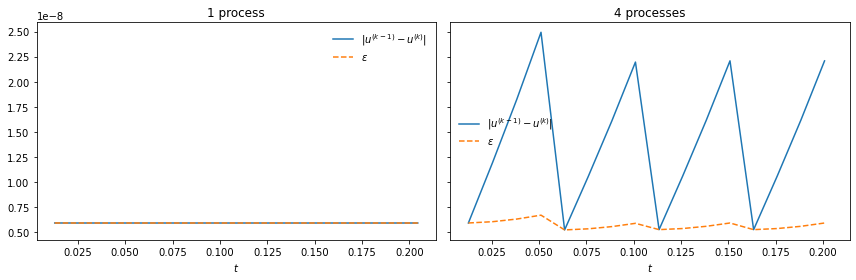

In [2]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
plot_embedded(run_advection(description, 1)[0], axs[0])
plot_embedded(run_advection(description, 4)[0], axs[1])
axs[0].set_title('1 process')
axs[1].set_title('4 processes')
fig.tight_layout()
plt.show()

What do we see here? Both panels show the difference of the solutions as well as the embedded error estimates, but for different processor counts.
In the left panel, we get the local error right from the difference of the two sweeps, but in the right plot, we need to take the difference between successive steps within a block to get the local error.
Now it does not agree with the serial estimate perfectly, but my feeling is that it's close enough for our purposes.

### Adaptivity<a id='adaptivity'></a>
The idea of adaptivity is founded on the concept of the time stepping scheme having some order $k$, which means that 
$$\frac{e^\prime_{n}}{e_n} = \left(\frac{h^\prime_{n}}{h_n}\right)^{k+1},$$
holds for how the local error $e$ of step $n$ changes when we change the step size $h$ to some other $h^\prime$.
Now, we can claim that the same relation holds for two consecutive time steps:
$$\frac{e_{n+1}}{e_n} = \left(\frac{h_{n+1}}{h_n}\right)^{k+1},$$
which is unfortunately not true, since the time scale of the problem might change between steps, but we will fix this later.
For now let's stick with this assumption and try to compute an optimal step size for the next step $h_{n+1}$from it.

We can rearrange and manipulate a bit to get
$$h_{n+1} = \beta h_n \left(\frac{\epsilon_\mathrm{tol}}{\epsilon_{n}}\right)^{1/k}.$$
A couple of things happened here: First, we replaced the error of the next step by the tolerance that we set.
Then, we put in a safety factor of $\beta=0.9$ to avoid too many restarts (more on that in a second).
The most drastic change, however, is the drop in the exponent from $k+1$ to $k$.
We do this, because we are actually estimating the error of the second to last sweep with the embedded estimate, which is order $k$, as discussed [above](#embedded_estimate).

Now, we promised a fix for using a wrong assumption and it is very simple!
We just add one extra step which makes sure we are actually solving the problem to the accuracy that we want and that is comparing the local error estimate to the tolerance that we set.
If $\epsilon \leq \epsilon_\mathrm{TOL}$, we move on to step $n+1$ and compute it with whatever step size we computed.
Otherwise, we restart step $n$ with the new step size.

Since only very boring equations actually have the same time scale accross all steps, we use the safety factor $\beta$ such that we don't need to restart if the problem got just a bit faster.
But most changes in time scale should be accounted for by maximum one restart, because after the restart we are in the realm of the first equation, which is mathematically sound and not just heuristics.

In serial, applying this scheme is super easy, but in parallel the question is: How do we use the step size computed with adaptivity, when we are already $k-1$ iterations into the step in question, after computing a step size for it?
The easiest answer seems to be to treat the problem in the block structure that is inherent to block Gauss-Seidel, and to have the all steps in a block have the same step size.

To get a bit more precise about what I mean by block: Each step is a collocation problem with $M$ nodes and each block contains $N$ steps, such that a block of steps contains $N\times M$ collocation nodes.

Let's demonstrate how a step size distribution using adaptivity looks in the van der Pol problem.

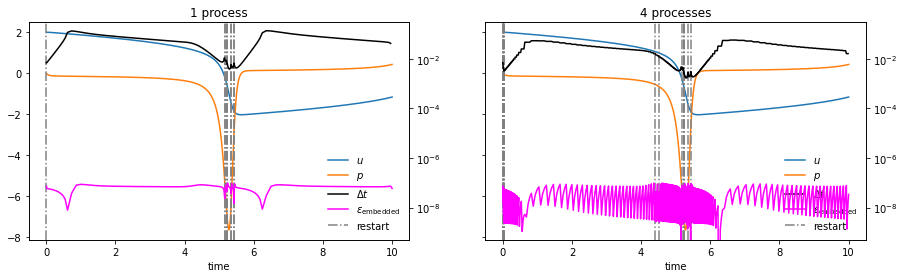

In [3]:
from vdp import run_vdp, plot_step_sizes

# change only the things in the description that we need for adaptivity
adaptivity_params = dict()
adaptivity_params['e_tol'] = 1e-7

convergence_controllers = dict()
convergence_controllers[Adaptivity] = adaptivity_params

description = dict()
description['convergence_controllers'] = convergence_controllers

fig, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True, sharey=True)
plot_step_sizes(run_vdp(description, 1)[0], axs[0])
plot_step_sizes(run_vdp(description, 4)[0], axs[1])
axs[0].set_title('1 process')
axs[1].set_title('4 processes')
plt.show()

The two components of the solution $u$ and $p$ are plotted in linear scale on the left axis, while step size and embedded error estimate are plotted on the log scale on the right axis.
The embedded error is supposed to stay below a threshold of $10^{-7}$ and it does, but it wobbles about quite a bit when using multiple processes, owing to the non-linearity of this equation.

The details of the PinT extension go like this: We solve the entire block as usual with the same step size accross all steps in the block.
Then, we estimate the local error, check if the accuracy was reached and compute new step sizes, without distributing them to any steps just yet.
Now, we look at the whole block to see which was the first step not to reach the accuracy we want or if they all did.
This let's us decide whether to start the new block from the solution to the last step of the current block or with the initial conditions of the first step that triggers a restart.
Finally, we give each step the step size computed with adaptivity on the same step that we use for initial conditions of the next block and then we start the next block.

The result is the staircase pattern in the step sizes in the right panel.
A better scheme would allow to give the steps different step sizes, but that's not straightforward, since extrapolation of step sizes for instance is dangerous business in the world of non-linear equations.
But I will make an attempt at finding someting better in the future.

#### How can you use adaptivity with pySDC? <a id='how_to'></a>
It really is very simple.
As you can gather from the equations above, we do not introduce many more parameters, but we replace the time step by a tolerance.
You should still put in a time step size, because that will be the starting guess, so it would ideally be close to what you want the step size to be.

Adaptivity is implemented as convergence controller and can be imported using the following statement:
```
from pySDC.implementations.convergence_controller_classes.adaptivity import Adaptivity
```

Then you change the following parameters in the `description` object, just like in the above examples:
```
adaptivity_params = dict()
adaptivity_params['e_tol'] = <tolerance>

convergence_controllers = dict()
convergence_controllers[Adaptivity] = adaptivity_params

description['convergence_controllers'] = convergence_controllers
```

You also need to make sure you satisfy the assumptions that went into this implementation of adaptivity, which is mainly that you know the order and that it is fixed.
Please set the residual tolerance something smaller than 0 to make sure you always perform the same amount of iterations:
```
level_params['restol'] = -1.
```
It is initialized to -1, so if you don't explicitly set a value, that will also be fine.
Then you need to set an appropriate value for the iteration number and collocation nodes:
```
step_params['maxiter'] = <your iteration count>
sweeper_params['num_nodes'] = <sufficient number of nodes>
```
The number of iterations must be at least two for the embedded method to give something sensible and should probably not exceed 6 or so, just see if the step sizes are sensible at the order you choose.
There is no one-size-fits-all recipe here.

Also, choose your preconditioner wisely!
The order should rise by one with each sweep but you can run into issues with different preconditioners, so make sure they behave well.

When doing PinT, adaptivity is only implemented in block Gauss-Seidel mode, so you need to set
```
controller_params['mssdc_jac'] = False
```

To monitor the restarts simply put the following in the `post_step` hook:
```
self.increment_stats(process=step.status.slot, time=L.time, level=L.level_index, iter=0,
                     sweep=L.status.sweep, type='restart', value=int(step.status.restart))
```
The increment stats function allows to count when the same step has been restarted multiple times.
To filter out any unwanted values when doing PinT that have been recorded but then restarted and not overridden because the step sizes are now different, use the `recomputed=False` attribute in the functions on the stats object, which uses the same `steps.status.restart` variable which is recorded in each `post_step` hook by default.

Finally, care must be taken with the time that is associated with the solutions.
Usually, I see `post_step` hooks recording the solution of the step at time `L.t`, which is the beginning of the step, but what is acutally recorded is the solution at the end of the step.
With fixed step sizes, this is a constant offset that doesn't matter much, but with adaptive step sizes, especially when there is a big jump, this mismatch will show up as wobbles or kinks in plots.
But don't dispair!
This is entirely a plotting artifact that you can get rid of by chosing `time=L.time + L.dt` as the time when you record the solution in the hook.
Of course, you can still choose to attribute the step size to the beginning of the step for instance and record different quantities at different times in the same hook.